In [60]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)

In [61]:
df = pd.read_csv('vehicles_cleaned.csv',index_col= 0)


In [62]:
df.shape

(304051, 12)

In [63]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304051 entries, 0 to 312725
Data columns (total 12 columns):
price           304051 non-null int64
year            304051 non-null float64
manufacturer    304051 non-null object
model           304051 non-null object
condition       304051 non-null object
cylinders       304051 non-null object
fuel            304051 non-null object
odometer        304051 non-null float64
transmission    304051 non-null object
drive           304051 non-null object
size            304051 non-null object
type            304051 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 30.2+ MB


None

In [64]:
#Change 'Cylinders' Column to Numerical 
cleanup_nums = {"12 cylinders" : 12, "10 cylinders": 10,"8 cylinders": 8,"6 cylinders": 6,'5 cylinders':5,"4 cylinders":4,"3 cylinders": 3 }
df.cylinders.replace(cleanup_nums, inplace=True, regex=True)
df.cylinders.value_counts()

6     105339
4     103661
8      91412
5       1802
10      1574
3        249
12        14
Name: cylinders, dtype: int64

In [65]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304051 entries, 0 to 312725
Data columns (total 12 columns):
price           304051 non-null int64
year            304051 non-null float64
manufacturer    304051 non-null object
model           304051 non-null object
condition       304051 non-null object
cylinders       304051 non-null int64
fuel            304051 non-null object
odometer        304051 non-null float64
transmission    304051 non-null object
drive           304051 non-null object
size            304051 non-null object
type            304051 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 30.2+ MB


None

In [66]:
display(df.head())

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type
0,6450,2006.0,acura,200,excellent,6,gas,122000.0,automatic,fwd,full-size,sedan
1,5270,2006.0,acura,200,excellent,6,gas,103000.0,automatic,fwd,mid-size,sedan
2,3500,1991.0,audi,200,good,5,gas,120000.0,automatic,4wd,mid-size,sedan
3,8000,2010.0,chevrolet,200,good,6,gas,100000.0,automatic,fwd,full-size,sedan
4,8000,2016.0,chevrolet,200,good,6,gas,70000.0,automatic,fwd,full-size,sedan


In [67]:
#missing values
df.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
size            0
type            0
dtype: int64

In [68]:
df.condition.value_counts()

good         187392
excellent     93406
like new      18696
fair           3936
new             378
salvage         243
Name: condition, dtype: int64

In [69]:
#dropping cars that are new or non- functional
df = df[~(df['condition'] == 'salvage')]
df = df[~(df['condition'] == 'new')]
df.condition.value_counts()

good         187392
excellent     93406
like new      18696
fair           3936
Name: condition, dtype: int64

In [70]:
pd.set_option('display.max_rows', 200)
model = pd.DataFrame(df.model.value_counts().reset_index())
model.columns = ['model', 'count']
print(model)

# merge 'df' & 'brands_count'
df = pd.merge(df, model, on='model')


                model  count
0           silverado  17141
1                 500  15647
2               f-150   9859
3              sierra   7314
4            wrangler   6944
5                 ion   6709
6      grand cherokee   5482
7                  x4   4939
8              escape   4829
9               f-250   4788
10             accord   4652
11              civic   4489
12              camry   4331
13                van   4099
14             altima   3945
15             tacoma   3750
16              f-350   3679
17            equinox   3584
18              focus   3530
19             tundra   3329
20            mustang   3260
21           explorer   3136
22                xlt   3119
23              rogue   3054
24               cr-v   2944
25            corolla   2908
26                300   2798
27             malibu   2762
28              tahoe   2684
29             impala   2559
30            outback   2455
31              cruze   2440
32               edge   2357
33            

In [71]:
df = df[(df['count'] > 600)]
df.model.value_counts().count()

124

In [72]:
df['size'].value_counts()

full-size      156196
mid-size        81334
compact         34687
sub-compact      5024
Name: size, dtype: int64

In [73]:
# setting sub-compact = compact
df['size'] = df['size'].apply(lambda x: 'compact' if 'sub-compact' in x else x)
df['size'].value_counts()

full-size    156196
mid-size      81334
compact       39711
Name: size, dtype: int64

In [74]:
#dropping 'cylinders' >3 & <12
df = df[df['cylinders'] > 3]
df = df[df['cylinders'] < 12]
df.cylinders.value_counts().count()

5

In [75]:
df['type'].value_counts()

SUV            74356
sedan          63158
pickup         43645
truck          42340
coupe           9703
wagon           8832
van             8731
hatchback       8550
other           7869
mini-van        5618
convertible     3359
offroad          590
bus              258
Name: type, dtype: int64

In [76]:
#setting pickup == truck , dropping bus
df['type'] = df['type'].apply(lambda x: 'truck' if 'pickup' in x else x)
df = df[~(df['type'] == 'bus')]


In [77]:
df.shape

(276751, 13)

In [78]:
df.model.value_counts()

silverado           17141
500                 15629
f-150                9856
sierra               7312
wrangler             6940
ion                  6653
grand cherokee       5481
x4                   4923
escape               4827
f-250                4787
accord               4650
civic                4485
camry                4330
van                  4066
altima               3945
tacoma               3750
f-350                3676
equinox              3584
focus                3499
tundra               3329
mustang              3260
explorer             3131
xlt                  3117
rogue                3054
cr-v                 2943
corolla              2906
300                  2781
malibu               2760
tahoe                2683
impala               2559
outback              2451
cruze                2440
edge                 2357
sonota               2243
elantra              2230
forester             2186
odyssey              2184
sentra               2156
town and cou

In [79]:
#convert categorical data into numerical 
from sklearn import preprocessing 
import pandas as pd
df = df.drop(columns= ['model','count'])

df= pd.get_dummies(df, prefix=['manufacturer','condition','fuel','drive','transmission','size','type'], columns=['manufacturer','condition','fuel','drive','transmission','size','type'])
df.shape
df.head()


,price,year,cylinders,odometer,manufacturer_acura,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_sedan,type_truck,type_van,type_wagon
0,6450,2006.0,6,122000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5270,2006.0,6,103000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3500,1991.0,5,120000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8000,2010.0,6,100000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,8000,2016.0,6,70000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [80]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import numpy as np
y = df.price.values
X = df.drop('price', axis= 1)
y = np.array(y)
features = list(X.columns)
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state= 40)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(193725, 63)
(193725,)
(83026, 63)
(83026,)


In [81]:
#scale with minmaxscaler
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()   
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)



In [82]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

reg_all = LinearRegression()


# # 5fold CV RMSE
MSE_CV_scores = -cross_val_score(reg_all, X_train, y_train, cv=5, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)
RMSE_CV = MSE_CV_scores.mean()**(1/2)
print('CV RMSE: {:.2f}'.format(RMSE_CV))

# Test set RMSE
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
rmse = np.sqrt(MSE(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
score = reg_all.score(X_test, y_test)
print(score)


CV RMSE: 5263.55
Root Mean Squared Error: 5205.5865132508925
0.7510684832213995


0.7432344371113822
5286.86369908212


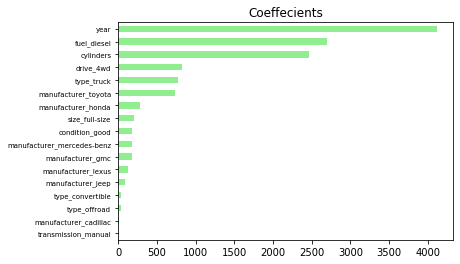

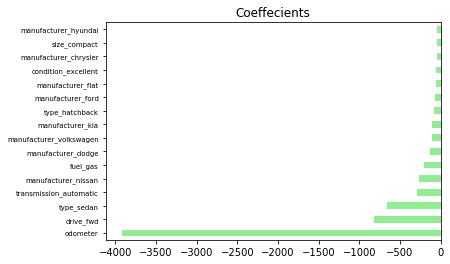

In [86]:
#Lasso Regression
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np

lasso = Lasso(alpha= 0.4, normalize=True)
lasso.fit(X_train,y_train)
prediction = lasso.predict(X_test)
score = lasso.score(X_test, y_test)
print(score)
rmse = np.sqrt(MSE(y_test, prediction))
print(rmse)
#graphing Lasso coefficents
importances = pd.Series(data=lasso.fit(X_train, y_train).coef_,
                        index= features)

# Sort importances
importances_sorted = importances.sort_values()
positive_importance = importances_sorted[importances_sorted > 0]
negative_importance = importances_sorted[importances_sorted < 0]

#positive and negative Lasso plots
positive_importance.plot(kind='barh', color='lightgreen')
plt.title('Coeffecients')
plt.yticks(horizontalalignment='right',
    fontweight='light',
    fontsize='x-small' )
plt.show()
negative_importance.plot(kind='barh', color='lightgreen')
plt.title('Coeffecients')
plt.yticks(horizontalalignment='right',
    fontweight='light',
    fontsize='x-small' )

plt.show()


In [92]:
#Decision Tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=200,
             min_samples_leaf=0.001,
            random_state=100)

# Fit dt to the training set
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test,y_pred)
rmse_dt = mse_dt**(1/2)
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 4431.33


In [93]:
MSE_CV_scores = -cross_val_score(dt, X_train, y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
RMSE_CV = MSE_CV_scores.mean()**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 4488.73


In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

rf = RandomForestRegressor(n_estimators=200,min_samples_leaf=0.01,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train,y_train) 

y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 5200.94


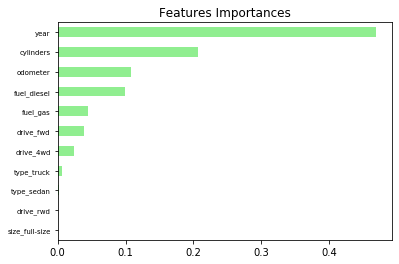

In [98]:
importances = pd.Series(data=rf.feature_importances_,
                        index= features)

# Sort importances
importances_sorted = importances.sort_values()
top_importance = importances_sorted[importances_sorted > 0]

# barplot of importances
top_importance.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.yticks(horizontalalignment='right',
    fontweight='light',
    fontsize='x-small' )


plt.show()

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
import pandas as pd
dt = DecisionTreeRegressor(max_depth=100,
             min_samples_leaf=0.01,
            random_state=100)
ada = AdaBoostRegressor(base_estimator=dt, n_estimators=70, random_state=1)          
# Fit Ada to the training set    
ada.fit(X_train,y_train) 
y_pred = ada.predict(X_test)


print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))





Mean Absolute Error: 5144.37
Mean Squared Error: 42111824.2
Root Mean Squared Error: 6489.36


In [101]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
mse_test = MSE(y_test,y_pred)

rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 4013.392


In [103]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV


sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=0.9,
            max_features=0.75,
            n_estimators=200,                                
            random_state=2)

params_rf = {'n_estimators':[100,350,500], 'max_features': ['log2','auto','sqrt']}
# GRIDsearch
grid_rf = GridSearchCV(estimator=sgbr,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)
# best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test,y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 13.3min finished


Test RMSE of best model: 3809.212


In [115]:
#XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)


params = {"booster":"gblinear", "objective":"reg:linear"}
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)


preds = xg_reg.predict(DM_test)
rmse = np.sqrt(MSE(y_test,preds))
print("RMSE: %f" % (rmse))


[20:52:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 5246.469329


[21:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


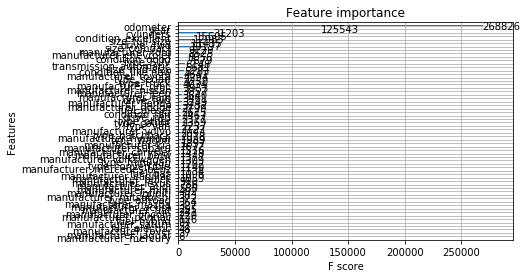

99    3247.453735
Name: test-rmse-mean, dtype: float64


In [123]:
#XGB boosting with 4-fold Cross Val
dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"reg:linear", "max_depth":20}


cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=4, num_boost_round=100, metrics="rmse", as_pandas=True, seed=123)

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=100)

# Importances Plot
xgb.plot_importance(xg_reg)
plt.show()

print((cv_results["test-rmse-mean"]).tail(1))

In [126]:
dmatrix = xgb.DMatrix(data=X, label=y)

params = {"objective":"reg:linear", "max_depth":80}
num_rounds = [15, 30, 50]
final_rmse_per_round = []


for curr_num_rounds in num_rounds:
     cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
        
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])


num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

       

[21:45:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [127]:
#XGBoosting with early stopping rounds =10
dmatrix = xgb.DMatrix(data=X,label=y)


params = {"objective":"reg:linear", "max_depth":20}

cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print((cv_results["test-rmse-mean"]).tail(1))


[21:52:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      12879.388021        7.228636    12911.232747      23.161839
1       9388.011719        5.904482     9481.525391      26.317801
2       6985.908366        5.930931     7182.770833      30.465047
3       5328.060872        5.340500     5681.279134      33.265487
4       4182.699544        6.550485     4734.348958      34.158504
5       3394.658203       10.200176     4152.632161      34.626919
6       2852.626302        8.788994     3812.203776      33.912806
7       2475.168376        7.807830     3616.582194      34.770974
8       2212.153890        4.289898     3502.6512

In [131]:
#Fine Tuning Learning rate
dmatrix = xgb.DMatrix(data=X, label=y)


params = {"objective":"reg:linear", "max_depth":20}


eta_vals = [0.2, 0.25, 0.3]
best_rmse = []

 
for curr_val in eta_vals:
    params["eta"] = curr_val
      
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=15,early_stopping_rounds=5, metrics="rmse", as_pandas=True, seed=123)
      
       
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])    

print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

[22:11:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:11:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [134]:
#Fine Tuning Max_depth
dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:linear"}

max_depths = [1,2,3,4]
best_rmse = []

for curr_val in max_depths:

    params["max_depths"] = curr_val
        
    cv_results = xgb.cv(dtrain= housing_dmatrix, params=params, nfold=3, num_boost_round=180,early_stopping_rounds=5, metrics="rmse", as_pandas=True, seed=123)
     
        
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

[22:17:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n